## Libraries

In [119]:
import torch
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import numpy as np
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Prepare Interactions

In [138]:
interactions_df = pd.read_json('/kaggle/input/goodreadspoetry/goodreads_interactions_poetry.json', lines=True)
books_df = pd.read_json('/kaggle/input/goodreadspoetry/goodreads_books_poetry.json', lines=True)

In [139]:
interactions_df.head()

,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
0,8842281e1d1347389f2ab93d60773d4d,1384,1bad0122cebb4aa9213f9fe1aa281f66,True,4,,Wed May 09 09:33:44 -0700 2007,Wed May 09 09:33:44 -0700 2007,,
1,8842281e1d1347389f2ab93d60773d4d,1376,eb6e502d0c04d57b43a5a02c21b64ab4,True,4,,Wed May 09 09:33:18 -0700 2007,Wed May 09 09:33:18 -0700 2007,,
2,8842281e1d1347389f2ab93d60773d4d,30119,787564bef16cb1f43e0f641ab59d25b7,True,5,,Sat Jan 13 13:44:20 -0800 2007,Wed Mar 22 11:45:08 -0700 2017,Tue Mar 01 00:00:00 -0800 1983,
3,72fb0d0087d28c832f15776b0d936598,24769928,8c80ee74743d4b3b123dd1a2e0c0bcac,False,0,,Wed Apr 27 11:05:51 -0700 2016,Wed Apr 27 11:05:52 -0700 2016,,
4,72fb0d0087d28c832f15776b0d936598,30119,2a83589fb597309934ec9b1db5876aaf,True,3,,Mon Jun 04 18:58:08 -0700 2012,Mon Jun 04 18:58:13 -0700 2012,,


In [140]:
# Drop columns
interactions = interactions_df.iloc[:, :5]
interactions.drop(columns=['review_id', 'is_read'], inplace=True)

# Keep only positive ratings (also removes 0's)
interactions = interactions[interactions_df['rating'] >= 3]

# Keep only users with 10 or more reviews
user_counts = interactions['user_id'].value_counts()
valid_users = user_counts[user_counts >= 10].index
interactions = interactions[interactions['user_id'].isin(valid_users)]

# Keep only books that appear 3 or more times
book_counts = interactions['book_id'].value_counts()
valid_books = book_counts[book_counts >= 3].index
interactions = interactions[interactions['book_id'].isin(valid_books)]

# Sample unique users
unique_users = interactions['user_id'].drop_duplicates().sample(5000, random_state=42)
interactions = interactions[interactions['user_id'].isin(unique_users)]

print(len(interactions))
interactions.head(10)

116541


,user_id,book_id,rating
825,467ed8f03548be6c2d9228f9a2f7b2ea,28645638,4
826,467ed8f03548be6c2d9228f9a2f7b2ea,410739,5
827,467ed8f03548be6c2d9228f9a2f7b2ea,1232475,4
829,467ed8f03548be6c2d9228f9a2f7b2ea,22716470,5
830,467ed8f03548be6c2d9228f9a2f7b2ea,609155,5
831,467ed8f03548be6c2d9228f9a2f7b2ea,6364068,3
832,467ed8f03548be6c2d9228f9a2f7b2ea,8496,5
833,467ed8f03548be6c2d9228f9a2f7b2ea,154387,5
834,467ed8f03548be6c2d9228f9a2f7b2ea,430788,4
835,467ed8f03548be6c2d9228f9a2f7b2ea,108137,5


In [141]:
print("Length: ", len(interactions))
print()
print("Rating Distribution")
print(interactions.groupby(['rating'])['rating'].count())
print()
print("Number of Unique Users", len(interactions['user_id'].unique()))
print("Number of Unique Books", len(interactions['book_id'].unique()))

Length:  116541

Rating Distribution
rating
3    23996
4    42299
5    50246
Name: rating, dtype: int64

Number of Unique Users 5000
Number of Unique Books 16673


In [142]:
unique_users = interactions['user_id'].unique()
unique_books = interactions['book_id'].unique()

#--- Producing new continuous integer IDs for users and books
# Unique values : index
userid2idx = {o:i for i,o in enumerate(unique_users)}
bookid2idx = {o:i for i,o in enumerate(unique_books)}

# Obtained continuous ID for users and books
idx2userid = {i:o for o,i in userid2idx.items()}
idx2bookid = {i:o for o,i in bookid2idx.items()}

# return the id from the indexed values as noted in the lambda function down below.
interactions['book_id'] = interactions['book_id'].apply(lambda x: bookid2idx[x])
interactions['user_id'] = interactions['user_id'].apply(lambda x: userid2idx[x])

print(interactions.head(5))

     user_id  book_id  rating
825        0        0       4
826        0        1       5
827        0        2       4
829        0        3       5
830        0        4       5


In [143]:
# Create two DataFrames for the original interactions and the sample
train = pd.DataFrame()
test = pd.DataFrame()

# For each unique user_id, sample 20% of the interactions and remove them from the original dataframe
user_ids = interactions['user_id'].unique()
for user in user_ids:
    # Get all interactions for the current user
    user_interactions = interactions[interactions['user_id'] == user]

    # Sample 20% of the interactions
    sample = user_interactions.sample(frac=0.2, random_state=42)
    
    train = pd.concat([train, user_interactions.drop(sample.index)], ignore_index=True)
    test = pd.concat([test, sample], ignore_index=True)

# Display the results
print("Training Data")
print(train.head())
print("Total rows in training data:", len(train))
print("Num Unique Users: ", train.user_id.nunique())

print("\nTesting Data")
print(test.head())
print("Total rows in testing data:", len(test))
print("Num Unique Users: ", test.user_id.nunique())

Training Data
   user_id  book_id  rating
0        0        2       4
1        0        3       5
2        0        4       5
3        0        5       3
4        0        6       5
Total rows in training data: 93323
Num Unique Users:  5000

Testing Data
   user_id  book_id  rating
0        0        0       4
1        0       17       5
2        0       15       5
3        0        1       5
4        1       48       4
Total rows in testing data: 23218
Num Unique Users:  5000


## Tensor Conversions

In [144]:
def convert_to_sparse_tensor(dok_mtrx):  
    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)
    values = dok_mtrx_coo.data
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor

## Metrics:  
##### Recall@K, Precision@K, NDCG@K, MAP@K

In [145]:
def get_hit_list(book_id, top_rlvnt_itm):
    return [1 if x in set(book_id) else 0 for x in top_rlvnt_itm ]

def get_dcg_idcg(book_id, hit_list):
    idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(book_id),len(hit_list)))])
    dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
    return dcg/idcg

def get_cumsum(hit_list):
    return np.cumsum(hit_list)

def get_map(book_id, hit_list, hit_list_cumsum):
    return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(book_id)

def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
    user_Embedding = nn.Embedding(user_Embed_wts.size()[0], user_Embed_wts.size()[1], _weight = user_Embed_wts)
    item_Embedding = nn.Embedding(item_Embed_wts.size()[0], item_Embed_wts.size()[1], _weight = item_Embed_wts)

    test_user_ids = torch.LongTensor(test_data['user_id'].unique())

    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
    R[train_data['user_id'], train_data['book_id']] = 1.0

    R_tensor = convert_to_sparse_tensor(R)
    R_tensor_dense = R_tensor.to_dense()

    R_tensor_dense = R_tensor_dense*(-np.inf)
    R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0)

    relevance_score = relevance_score+R_tensor_dense

    topk_relevance_score = torch.topk(relevance_score, K).values
    topk_relevance_indices = torch.topk(relevance_score, K).indices

    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])

    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
 
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    test_interacted_items = test_data.groupby('user_id')['book_id'].apply(list).reset_index()

    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.book_id, metrics_df.top_rlvnt_itm)]


    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['book_id']), axis = 1) 
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['book_id'], x['top_rlvnt_itm']), axis = 1)

    metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['book_id'], x['hit_list']), axis = 1)
    metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)

    metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['book_id'], x['hit_list'], x['hit_list_cumsum']), axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean() 

## LightGCN

In [146]:
class LightGCN(nn.Module):
    def __init__(self, data, n_users, n_items, n_layers, latent_dim):
        super(LightGCN, self).__init__()
        self.data = data
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self):
        self.E0 = nn.Embedding(self.n_users + self.n_items, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    def get_A_tilda(self):
        R = sp.dok_matrix((self.n_users, self.n_items), dtype = np.float32)
        R[self.data['user_id'], self.data['book_id']] = 1.0

        adj_mat = sp.dok_matrix(
                (self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32
            )
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[: n_users, n_users :] = R
        adj_mat[n_users :, : n_users] = R.T
        adj_mat = adj_mat.todok()

        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)
        
        # Below Code is toconvert the dok_matrix to sparse tensor.
        
        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))

        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape

        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor
    
    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.n_layers):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [n_users, n_items])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [n_users, n_items])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed

    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0

## Loss

In [147]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):
  
    reg_loss = (1/2)*(userEmb0.norm().pow(2) + 
                    posEmb0.norm().pow(2)  +
                    negEmb0.norm().pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)
        
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
        
    return loss, reg_loss

## DataLoader

In [148]:
def data_loader(data, batch_size, n_usr, n_itm):
  
    interected_items_df = data.groupby('user_id')['book_id'].apply(list).reset_index()

    indices = [x for x in range(n_usr)]
    
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()
  
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id', right_on = 'users')
    
    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id
  
    pos_items = interected_items_df['book_id'].apply(lambda x : random.choice(x)).values

    neg_items = interected_items_df['book_id'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)


## Initialize Model and Params

In [149]:
n_users = len(interactions['user_id'].unique())
n_items = len(interactions['book_id'].unique())

latent_dim = 64
n_layers = 3  

lightGCN = LightGCN(train, n_users, n_items, n_layers, latent_dim)
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 0.005)
EPOCHS = 40
BATCH_SIZE = 1024 
DECAY = 0.001
K = 10

## Train

In [150]:
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = [] 

total_start = time.time()
for epoch in tqdm(range(EPOCHS)):
    n_batch = int(len(train)/BATCH_SIZE)
  
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []
  
    best_ndcg = -1
  
    train_start_time = time.time()
    lightGCN.train()
    for batch_idx in range(n_batch):

        optimizer.zero_grad()

        users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items)

        users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)

        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)
        reg_loss = DECAY * reg_loss
        final_loss = mf_loss + reg_loss

        final_loss.backward()
        optimizer.step()

        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())


    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    lightGCN.eval()
    with torch.no_grad():
    
        final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
        test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)


    if test_topK_ndcg > best_ndcg:
        best_ndcg = test_topK_ndcg
      
        torch.save(final_user_Embed, 'final_user_Embed.pt')
        torch.save(final_item_Embed, 'final_item_Embed.pt')
        torch.save(initial_user_Embed, 'initial_user_Embed.pt')
        torch.save(initial_item_Embed, 'initial_item_Embed.pt')
     

    eval_time = time.time() - train_end_time

    loss_list_epoch.append(round(np.mean(final_loss_list),4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

    recall_list.append(round(test_topK_recall,4))
    precision_list.append(round(test_topK_precision,4))
    ndcg_list.append(round(test_topK_ndcg,4))
    map_list.append(round(test_topK_map,4))

    train_time_list.append(train_time)
    eval_time_list.append(eval_time)  


total_end = time.time()

total_train_time = total_end - total_start

  0%|          | 0/40 [00:00<?, ?it/s]

## Results

In [151]:
epoch_list = [(i+1) for i in range(EPOCHS)]

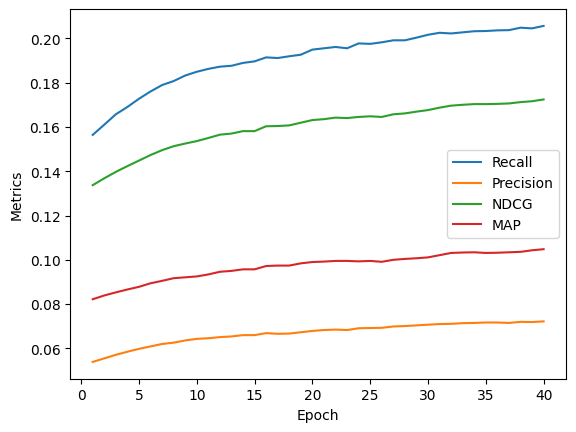

In [152]:
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

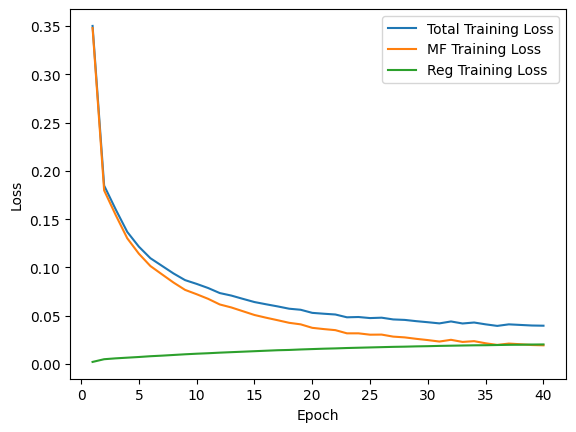

In [153]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [156]:
loss_list_epoch

[0.3501,
 0.1848,
 0.1601,
 0.1368,
 0.1216,
 0.1096,
 0.1017,
 0.0938,
 0.0869,
 0.083,
 0.0787,
 0.0735,
 0.0709,
 0.0675,
 0.0642,
 0.0619,
 0.0597,
 0.0573,
 0.0562,
 0.053,
 0.0521,
 0.0513,
 0.0484,
 0.0487,
 0.0476,
 0.048,
 0.0462,
 0.0457,
 0.0444,
 0.0433,
 0.0421,
 0.0441,
 0.042,
 0.043,
 0.0411,
 0.0395,
 0.0411,
 0.0405,
 0.0399,
 0.0397]

In [154]:
print("Averge time taken to train an epoch -> ", round(np.mean(train_time_list),2), " seconds")
print("Averge time taken to eval an epoch -> ", round(np.mean(eval_time_list),2), " seconds")
print("Total time -> ", total_train_time, " seconds")

Averge time taken to train an epoch ->  23.4  seconds
Averge time taken to eval an epoch ->  2.18  seconds
Total time ->  1023.3239648342133  seconds


In [155]:
print("Last Epoch's Test Data Recall -> ", recall_list[-1])
print("Last Epoch's Test Data Precision -> ", precision_list[-1])
print("Last Epoch's Test Data NDCG -> ", ndcg_list[-1])
print("Last Epoch's Test Data MAP -> ", map_list[-1])

print("Last Epoch's Train Data Loss -> ", loss_list_epoch[-1])

Last Epoch's Test Data Recall ->  0.2056
Last Epoch's Test Data Precision ->  0.0722
Last Epoch's Test Data NDCG ->  0.1724
Last Epoch's Test Data MAP ->  0.1048
Last Epoch's Train Data Loss ->  0.0397
